In [5]:
!pip install emoji
!pip install vaderSentiment
!pip install google-api-python-client
!pip install matplotlib
!pip install pandas
!pip install NRCLex
!pip install nltk
!pip install textblob
!python -m textblob.download_corpora

[nltk_data] Downloading package brown to /home/clayton/nltk_data...
[nltk_data]   Package brown is already up-to-date!
[nltk_data] Downloading package punkt to /home/clayton/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/clayton/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/clayton/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package conll2000 to
[nltk_data]     /home/clayton/nltk_data...
[nltk_data]   Package conll2000 is already up-to-date!
[nltk_data] Downloading package movie_reviews to
[nltk_data]     /home/clayton/nltk_data...
[nltk_data]   Package movie_reviews is already up-to-date!
Finished.


In [6]:
# Imports
from googleapiclient.discovery import build
from tqdm import tqdm
import pandas as pd
import os
import re
import emoji
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import matplotlib.pyplot as plt
from nrclex import NRCLex
import nltk

nltk.download('punkt')
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to /home/clayton/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /home/clayton/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [7]:
# Parameters
API_KEY = input('Enter Youtube API Key: ')
COMMENT_COUNT = 300
RELEVANCE_THRESHOLD = 0.65 # Percent of text vs emojis that determines if a comment is relevant
LINK_PATTERN = re.compile(r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\\(\\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
channel_name = input('Enter Youtube Channel Name: ')

In [8]:
YOUTUBE_API_SERVICE_NAME = 'youtube'
YOUTUBE_API_VERSION = 'v3'

youtube = build(YOUTUBE_API_SERVICE_NAME, YOUTUBE_API_VERSION, developerKey=API_KEY)

def get_all_videos_from_channel(channel_id):
    videos = []
    dates = []
    next_page_token = None

    response = youtube.channels().list(part='contentDetails', id=channel_id).execute()
    uploads_playlist_id = response['items'][0]['contentDetails']['relatedPlaylists']['uploads']

    while True:
        playlist_response = youtube.playlistItems().list(
            part='contentDetails',
            playlistId=uploads_playlist_id,
            maxResults=50,
            pageToken=next_page_token
        ).execute()

        videos += [item['contentDetails']['videoId'] for item in playlist_response['items']]
        dates += [item['contentDetails']['videoPublishedAt'] for item in playlist_response['items']]

        next_page_token = playlist_response.get('nextPageToken')

        if not next_page_token:
            break

    return videos, dates

# Find the channel id
search_response = youtube.search().list(
    q=channel_name,
    type='channel',
    part='id,snippet',
    maxResults=1
).execute()

if search_response['items']:
    channel_id = search_response['items'][0]['id']['channelId']
else:
    raise RuntimeError("Couldn't find channel id")

expected_file_name = f"{channel_name}.csv"
if os.path.exists(expected_file_name):
    df = pd.read_csv(expected_file_name)
else:
    ids, dates = get_all_videos_from_channel(channel_id)

    data = {'id': ids,
            'date': dates}

    df = pd.DataFrame(data)
    df = df.loc[::-1].reset_index(drop=True)
    df.to_csv(expected_file_name)

In [9]:
def get_video_stats(video_id):
    video_response = youtube.videos().list(part="statistics", id=video_id).execute()

    likes = video_response["items"][0]["statistics"]["likeCount"]
    views = video_response["items"][0]["statistics"]["viewCount"]
    comments = video_response["items"][0]["statistics"]["commentCount"]
    return likes, views, comments


def get_comments(video_id):
    comments = []
    nextPageToken = None
    while len(comments) < COMMENT_COUNT:
        request = youtube.commentThreads().list(
            part="snippet", videoId=video_id, maxResults=100, pageToken=nextPageToken
        )
        response = request.execute()
        for item in response["items"]:
            comment = item["snippet"]["topLevelComment"]["snippet"]
            # Check if the comment is not from the video uploader
            if comment["authorChannelId"]["value"] != channel_id:
                comments.append(comment["textDisplay"])
        nextPageToken = response.get("nextPageToken")

        if not nextPageToken:
            break
    return comments


def get_relevant_comments(video_id):
    relevant_comments = []

    comments = get_comments(video_id)

    for comment_text in comments:

        comment_text = comment_text.lower().strip()

        emojis = emoji.emoji_count(comment_text)

        text_characters = len(re.sub(r"\s", "", comment_text))

        # If a comment is mostly emojis or contains a link then consider it not relevant
        if (any(char.isalnum() for char in comment_text)) and not LINK_PATTERN.search(
            comment_text
        ):
            if (
                emojis == 0
                or (text_characters / (text_characters + emojis)) > RELEVANCE_THRESHOLD
            ):
                relevant_comments.append(comment_text)

    return relevant_comments


def get_comment_sentiment(comment):
    sentiment_object = SentimentIntensityAnalyzer()
    sentiment_dict = sentiment_object.polarity_scores(comment)
    return sentiment_dict["compound"]


def get_nrc(comment):
    emotion = NRCLex(comment)
    frequencies = emotion.affect_frequencies
    return frequencies


def get_sentiment(video_id):
    comments = get_relevant_comments(video_id)

    polarities = []
    positive_count = 0
    negative_count = 0
    neutral_count = 0
    fear = []
    anger = []
    trust = []
    surprise = []
    positive = []
    negative = []
    sadness = []
    disgust = []
    joy = []
    anticipation = []

    for comment in comments:
        polarity = get_comment_sentiment(comment)
        polarities.append(polarity)

        nrc = get_nrc(comment)
        fear.append(nrc["fear"])
        anger.append(nrc["anger"])
        trust.append(nrc["trust"])
        surprise.append(nrc["surprise"])
        positive.append(nrc["positive"])
        negative.append(nrc["negative"])
        sadness.append(nrc["sadness"])
        disgust.append(nrc["disgust"])
        joy.append(nrc["joy"])

        if "anticipation" in nrc:
            anticipation.append(nrc["anticipation"])
        else:
            anticipation.append(nrc["anticip"])

        if polarity > 0.05:
            positive_count += 1
        elif polarity < -0.05:
            negative_count += 1
        else:
            neutral_count += 1

    avg_polarity = sum(polarities) / len(polarities)
    avg_anger = sum(anger) / len(anger)
    avg_fear = sum(fear) / len(fear)
    avg_trust = sum(trust) / len(trust)
    avg_surprise = sum(surprise) / len(surprise)
    avg_positive = sum(positive) / len(positive)
    avg_negative = sum(negative) / len(negative)
    avg_sadness = sum(sadness) / len(sadness)
    avg_disgust = sum(disgust) / len(disgust)
    avg_joy = sum(joy) / len(joy)
    avg_anticipation = sum(anticipation) / len(anticipation)

    return (
        avg_polarity,
        positive_count,
        negative_count,
        neutral_count,
        avg_anger,
        avg_fear,
        avg_trust,
        avg_surprise,
        avg_positive,
        avg_negative,
        avg_sadness,
        avg_disgust,
        avg_joy,
        avg_anticipation,
    )


expected_stats_file = f"{channel_name}.stats.csv"
if os.path.exists(expected_stats_file):
    df = pd.read_csv(expected_stats_file)
else:
    like_counts = []
    view_counts = []
    comment_counts = []
    avg_polarities = []
    positive_counts = []
    negative_counts = []
    neutral_counts = []
    avg_anger_per = []
    avg_fear_per = []
    avg_trust_per = []
    avg_surprise_per = []
    avg_positive_per = []
    avg_negative_per = []
    avg_sadness_per = []
    avg_disgust_per = []
    avg_joy_per = []
    avg_anticipation_per = []

    for video_id in tqdm(df["id"].tolist()):
        like_count, view_count, comment_count = get_video_stats(video_id)
        (
            avg_polarity,
            positive_count,
            negative_count,
            neutral_count,
            avg_anger,
            avg_fear,
            avg_trust,
            avg_surprise,
            avg_positive,
            avg_negative,
            avg_sadness,
            avg_disgust,
            avg_joy,
            avg_anticipation,
        ) = get_sentiment(video_id)

        like_counts.append(like_count)
        view_counts.append(view_count)
        comment_counts.append(comment_count)
        avg_polarities.append(avg_polarity)
        positive_counts.append(positive_count)
        negative_counts.append(negative_count)
        neutral_counts.append(neutral_count)
        avg_anger_per.append(avg_anger)
        avg_fear_per.append(avg_fear)
        avg_trust_per.append(avg_trust)
        avg_surprise_per.append(avg_surprise)
        avg_positive_per.append(avg_positive)
        avg_negative_per.append(avg_negative)
        avg_sadness_per.append(avg_sadness)
        avg_disgust_per.append(avg_disgust)
        avg_joy_per.append(avg_joy)
        avg_anticipation_per.append(avg_anticipation)


    data = {
        "id": df["id"].tolist(),
        "date": df["date"].tolist(),
        "like_count": like_counts,
        "view_count": view_counts,
        "comment_count": comment_counts,
        "sentiment": avg_polarities,
        "positive_count": positive_counts,
        "negative_count": negative_counts,
        "neutral_count": neutral_counts,
        "avg_anger_per": avg_anger_per,
        "avg_fear_per": avg_fear_per,
        "avg_trust_per": avg_trust_per,
        "avg_surprise_per": avg_surprise_per,
        "avg_positive_per": avg_positive_per,
        "avg_negative_per": avg_negative_per,
        "avg_sadness_per": avg_sadness_per,
        "avg_disgust_per": avg_disgust_per,
        "avg_joy_per": avg_joy_per,
        "avg_anticipation_per": avg_anticipation_per
    }

    df = pd.DataFrame(data)
    df.to_csv(expected_stats_file)

In [10]:
df = pd.read_csv(expected_stats_file)

df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%dT%H:%M:%SZ')
df.set_index('date', inplace=True)

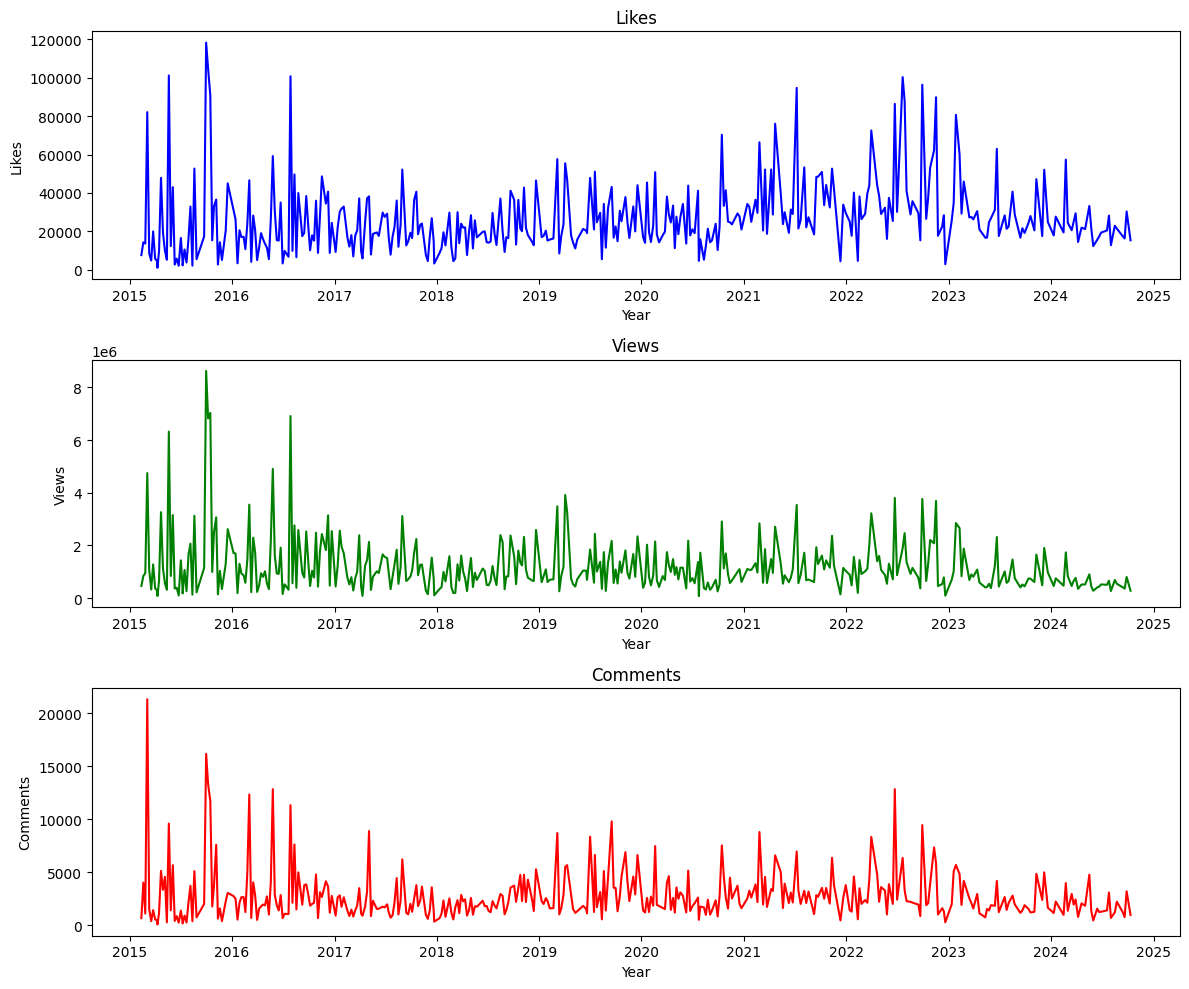

In [11]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 10))

ax1.plot(df.index, df['like_count'], label='Likes', color='blue')
ax1.set_title('Likes')
ax1.set_xlabel('Year')
ax1.set_ylabel('Likes')

ax1.xaxis.set_major_locator(plt.matplotlib.dates.YearLocator())
ax1.xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y'))

ax2.plot(df.index, df['view_count'], label='Views', color='green')
ax2.set_title('Views')
ax2.set_xlabel('Year')
ax2.set_ylabel('Views')

ax2.xaxis.set_major_locator(plt.matplotlib.dates.YearLocator())
ax2.xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y'))

ax3.plot(df.index, df['comment_count'], label='Comments', color='red')
ax3.set_title('Comments')
ax3.set_xlabel('Year')
ax3.set_ylabel('Comments')

ax3.xaxis.set_major_locator(plt.matplotlib.dates.YearLocator())
ax3.xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y'))

plt.tight_layout()

plt.show()


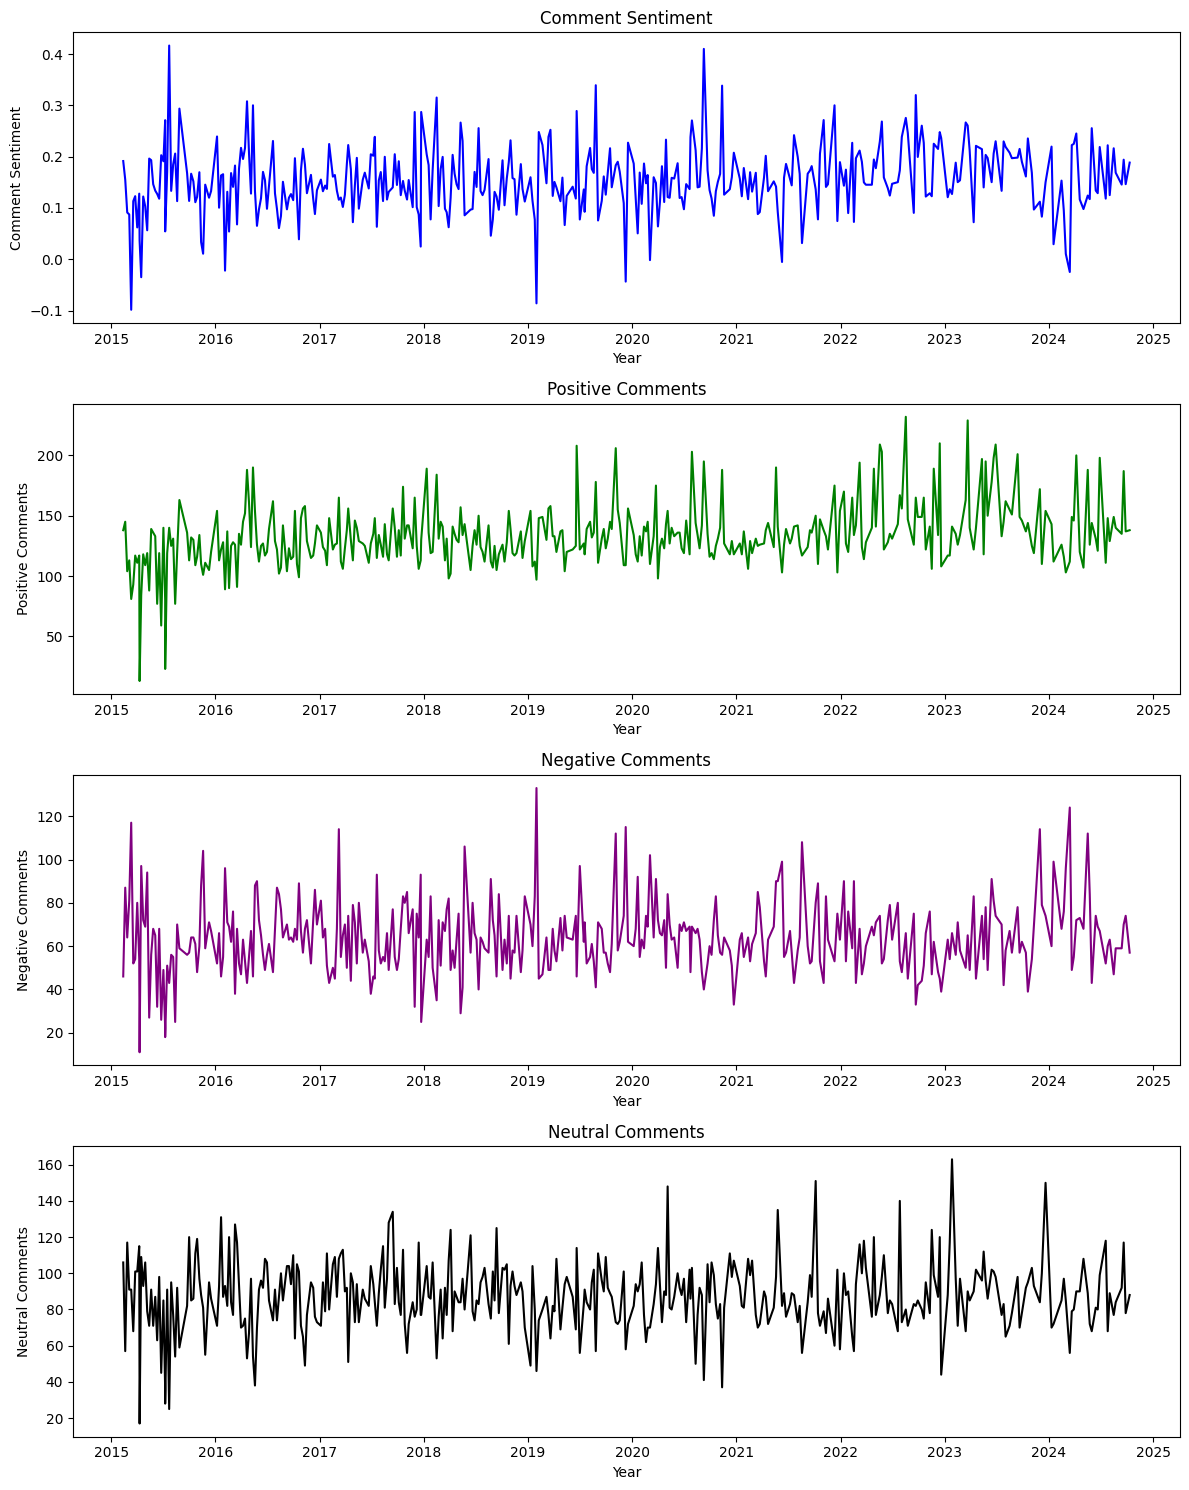

In [14]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(12, 15))  

ax1.plot(df.index, df['sentiment'], label='Comment Sentiment', color='blue')
ax1.set_title('Comment Sentiment')
ax1.set_xlabel('Year')
ax1.set_ylabel('Comment Sentiment')

ax1.xaxis.set_major_locator(plt.matplotlib.dates.YearLocator())
ax1.xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y'))

ax2.plot(df.index, df['positive_count'], label='Positive Comments', color='green')
ax2.set_title('Positive Comments')
ax2.set_xlabel('Year')
ax2.set_ylabel('Positive Comments')

ax2.xaxis.set_major_locator(plt.matplotlib.dates.YearLocator())
ax2.xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y'))

ax3.plot(df.index, df['negative_count'], label='Negative Comments', color='purple')
ax3.set_title('Negative Comments')
ax3.set_xlabel('Year')
ax3.set_ylabel('Negative Comments')

ax3.xaxis.set_major_locator(plt.matplotlib.dates.YearLocator())
ax3.xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y'))

ax4.plot(df.index, df['neutral_count'], label='Neutral Comments', color='black')
ax4.set_title('Neutral Comments')
ax4.set_xlabel('Year')
ax4.set_ylabel('Neutral Comments')

ax4.xaxis.set_major_locator(plt.matplotlib.dates.YearLocator())
ax4.xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y'))


plt.tight_layout()

plt.show()


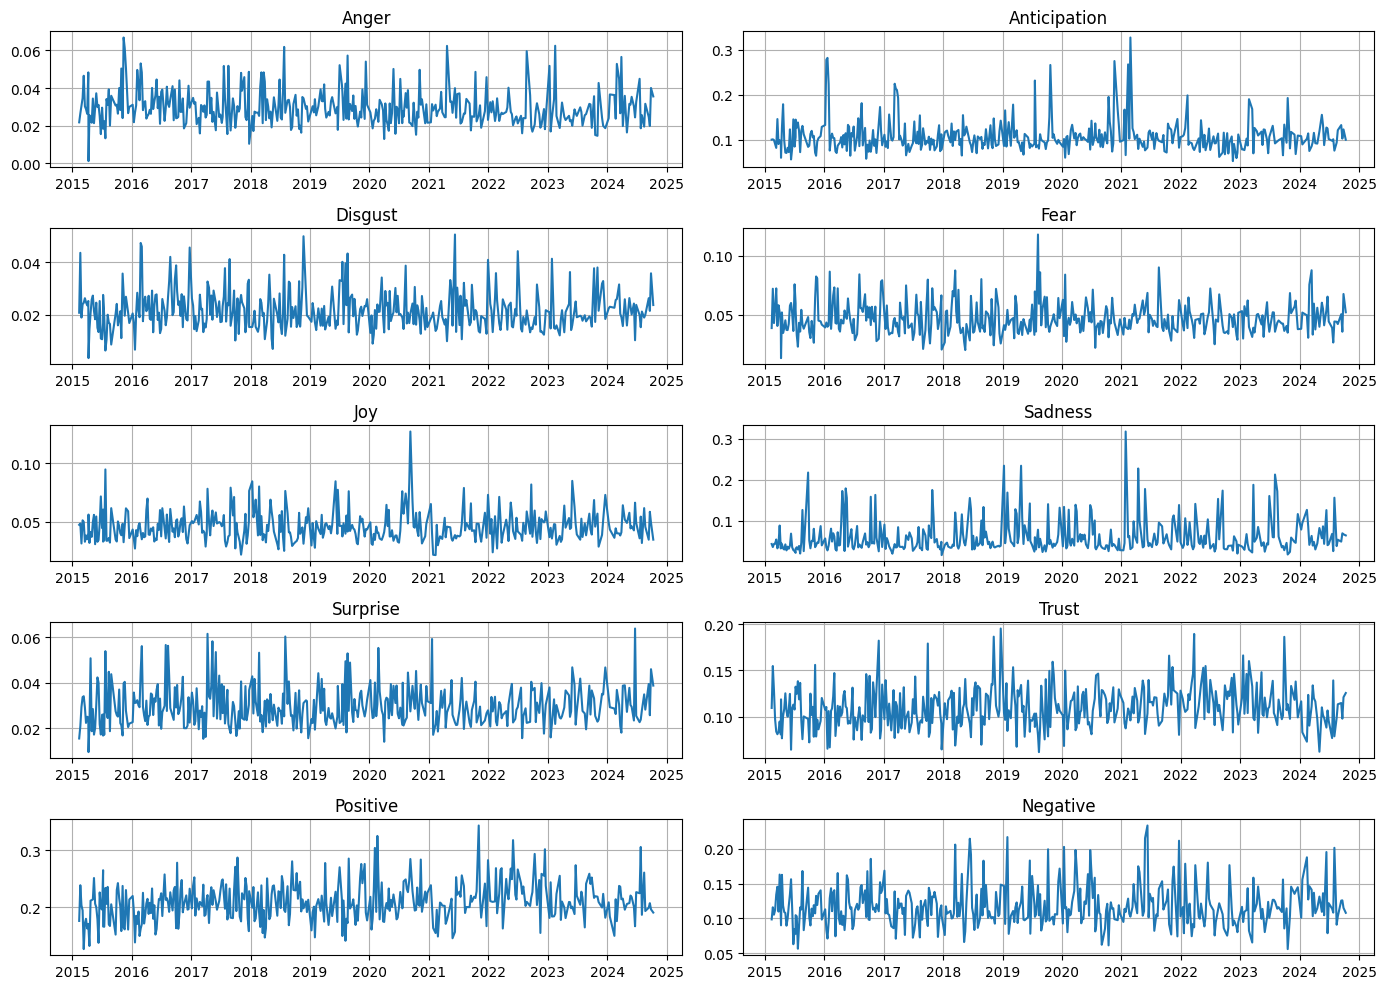

In [17]:
fig, axs = plt.subplots(5, 2, figsize=(14, 10))  

emotions = ['Anger', 'Anticipation', 'Disgust', 'Fear', 'Joy', 'Sadness', 'Surprise', 'Trust', 'Positive', 'Negative']
column = ['avg_anger_per', 'avg_anticipation_per', 'avg_disgust_per', 'avg_fear_per', 'avg_joy_per', 'avg_sadness_per', 'avg_surprise_per', 'avg_trust_per', 'avg_positive_per', 'avg_negative_per']

for i, emotion in enumerate(emotions):
    ax = axs[i // 2, i % 2]
    ax.plot(df.index, df[column[i]], label=emotion)
    ax.set_title(emotion)
    ax.grid(True)

# Adjust layout
plt.tight_layout()
plt.show()

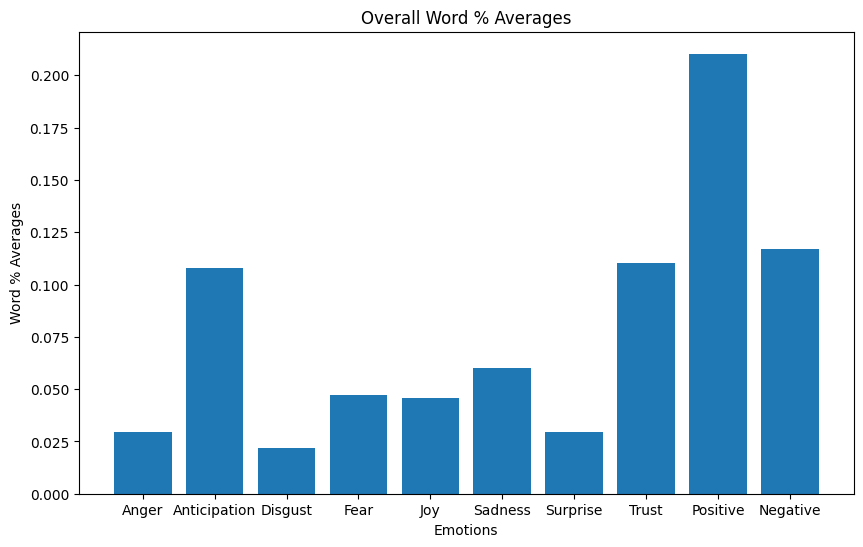

In [18]:
# Creating the bar chart

avgs = []
for index, col in enumerate(column):
    values = df[col].tolist()
    avg = sum(values)/len(values)
    avgs.append(avg)

plt.figure(figsize=(10, 6))

plt.bar(emotions, avgs)

# Adding labels and title
plt.xlabel('Emotions')
plt.ylabel('Word % Averages')
plt.title('Overall Word % Averages')

# Display the chart
plt.show()
    